[home](http://www.brandonrose.org)

# Document Clustering with Python

<img src='header_short.jpg'>

In this guide, I will explain how to cluster a set of documents using Python. My motivating example is to identify the latent structures within the synopses of the top 100 films of all time (per an IMDB list). See [the original post](http://www.brandonrose.org/top100) for a more detailed discussion on the example. This guide covers:

<ul>
<li> tokenizing and stemming each synopsis
<li> transforming the corpus into vector space using [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf)
<li> calculating cosine distance between each document as a measure of similarity
<li> clustering the documents using the [k-means algorithm](http://en.wikipedia.org/wiki/K-means_clustering)
<li> using [multidimensional scaling](http://en.wikipedia.org/wiki/Multidimensional_scaling) to reduce dimensionality within the corpus
<li> plotting the clustering output using [matplotlib](http://matplotlib.org/) and [mpld3](http://mpld3.github.io/)
<li> conducting a hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
<li> plotting a Ward dendrogram
<li> topic modeling using [Latent Dirichlet Allocation (LDA)](http://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)
</ul>

## Contents

<ul>
<li>[Stopwords, stemming, and tokenization](#Stopwords,-stemming,-and-tokenizing)
<li>[Tf-idf and document similarity](#Tf-idf-and-document-similarity)
<li>[K-means clustering](#K-means-clustering)
<li>[Multidimensional scaling](#Multidimensional-scaling)
<li>[Visualizing document clusters](#Visualizing-document-clusters)
<li>[Hierarchical document clustering](#Hierarchical-document-clustering)
<li>[Latent Dirichlet Allocation (LDA)](#Latent-Dirichlet-Allocation)
<li>[Visualizing LDA models](#Visualizing-LDA-models)
</ul>

But first, I import everything I am going to need up front

In [1]:
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

# Stopwords, stemming, and tokenizing

In [2]:
#import three lists: titles, links and wikipedia synopses
titles = open('title_list.txt').read().split('\n')
#ensures that only the first 100 are read in
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_wiki.append(text)

synopses_wiki = synopses_clean_wiki
    
    
genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


In [3]:
synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    #strips html formatting and converts to unicode
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb

In [4]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

In [5]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

This section is focused on defining some functions to manipulate the synopses. First, I load [NLTK's](http://www.nltk.org/) list of English stop words. [Stop words](http://en.wikipedia.org/wiki/Stop_words) are words like "a", "the", or "in" which don't convey significant meaning. I'm sure there are much better explanations of this out there.

In [6]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

Next I import the [Snowball Stemmer](http://snowball.tartarus.org/) which is actually part of NLTK. [Stemming](http://en.wikipedia.org/wiki/Stemming) is just the process of breaking a word down into its root.

In [7]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")


Below I define two functions:

<ul>
<li> *tokenize_and_stem*: tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token <li> *tokenize_only*: tokenizes the synopsis only
</ul>

I use both these functions to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes. Guess what, I do want to do that!



In [8]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [9]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these two lists, I create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. The downside here is that stems to tokens are one to many: the stem 'run' could be associated with 'ran', 'runs', 'running', etc. For my purposes this is fine--I'm perfectly happy returning the first token associated with the stem I need to look up.

In [10]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

## Tf-idf and document similarity

<img src='http://www.jiem.org/index.php/jiem/article/viewFile/293/252/2402' align='right' style="margin-left:10px">

Here, I define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the *synopses* list into a tf-idf matrix. 

To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

A couple things to note about the parameters I define below:

<ul>
<li> max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
<li> min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
<li> ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See [n-grams](http://en.wikipedia.org/wiki/N-gram)
</ul>

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 12 s, sys: 262 ms, total: 12.3 s
Wall time: 12.7 s
(100, 563)


In [12]:
terms = tfidf_vectorizer.get_feature_names()

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose [k-means](http://en.wikipedia.org/wiki/K-means_clustering). K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and  centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima. 

In [14]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 92.3 ms, sys: 2.11 ms, total: 94.4 ms
Wall time: 97.4 ms


In [15]:
from sklearn.externals import joblib

#joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [16]:
import pandas as pd

films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [17]:
frame['cluster'].value_counts()

4    26
0    25
2    21
1    16
3    12
dtype: int64

In [18]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()

cluster
0    47.200000
1    58.875000
2    49.380952
3    54.500000
4    43.730769
Name: rank, dtype: float64

In [19]:
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: family, home, mother, war, house, dies,

Cluster 0 titles: Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, The Silence of the Lambs, Gandhi, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Pianist, The Exorcist, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, The Graduate, Stagecoach, Wuthering Heights,

Cluster 1 words: police, car, killed, murders, driving, house,

Cluster 1 titles: Casablanca, Psycho, Sunset Blvd., Vertigo, Chinatown, Amadeus, High Noon, The French Connection, Fargo, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest,

Cluster 2 words: father, new, york, new, brothers, apartments,

Cluster 2 titles: The Godfather, Raging Bull, Citizen Kane,

In [20]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [21]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Rank</th>
      <th>Title</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>5</td>
      <td>Casablanca</td>
    </tr>
    <tr>
      <td>13</td>
      <td>Psycho</td>
    </tr>
    <tr>
      <td>14</td>
      <td>Sunset Blvd.</td>
    </tr>
    <tr>
      <td>15</td>
      <td>Vertigo</td>
    </tr>
    <tr>
      <td>24</td>
      <td>Chinatown</td>
    </tr>
    <tr>
      <td>31</td>
      <td>Amadeus</td>
    </tr>
    <tr>
      <td>57</td>
      <td>High Noon</td>
    </tr>
    <tr>
      <td>64</td>
      <td>The French Connection</td>
    </tr>
    <tr>
      <td>77</td>
      <td>Fargo</td>
    </tr>
    <tr>
      <td>87</td>
      <td>Pulp Fiction</td>
    </tr>
    <tr>
      <td>91</td>
      <td>The Maltese Falcon</td>
    </tr>
    <tr>
      <td>92</td>
      <td>A Clockwork Orange</td>
    </tr>
    <tr>
      <td>95</td>
      <td>Double Indemnity</td>
    </tr>
    <tr

# Multidimensional scaling

In [22]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [23]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In [24]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

In [25]:
%matplotlib inline

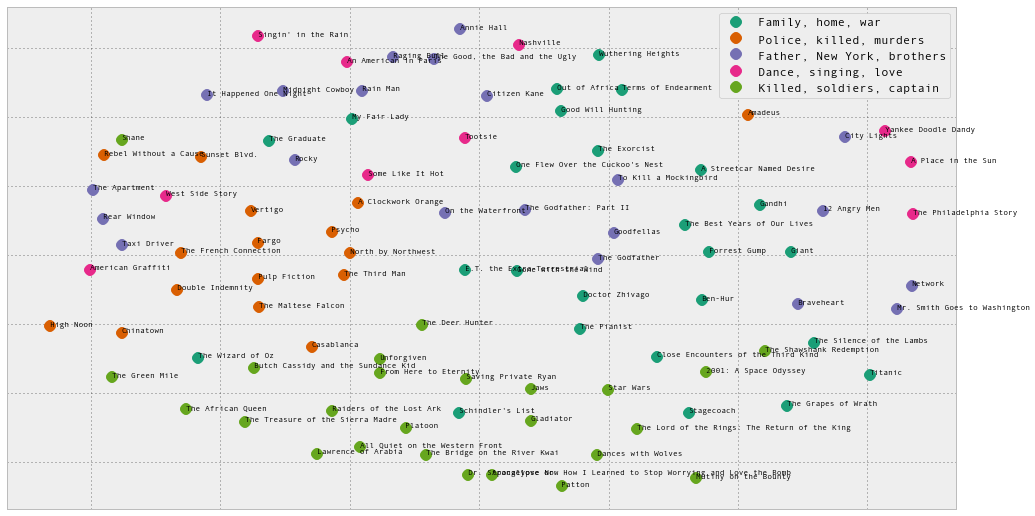

In [26]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [27]:
plt.close()

The clustering plot looks great, but it pains my eyes to see overlapping labels. Having some experience with [D3.js](http://d3js.org/) I knew one solution would be to use a browser based/javascript interactive. Fortunately, I recently stumbled upon [mpld3](https://mpld3.github.io/) a matplotlib wrapper for D3. Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover, which is what I am interested in.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. Don't worry about it too much and you actually don't need to use it, but it helped for formatting purposes when exporting to the web later. The only thing you might want to change is the x and y attr for the position of the toolbar.

In [28]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [29]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical document clustering

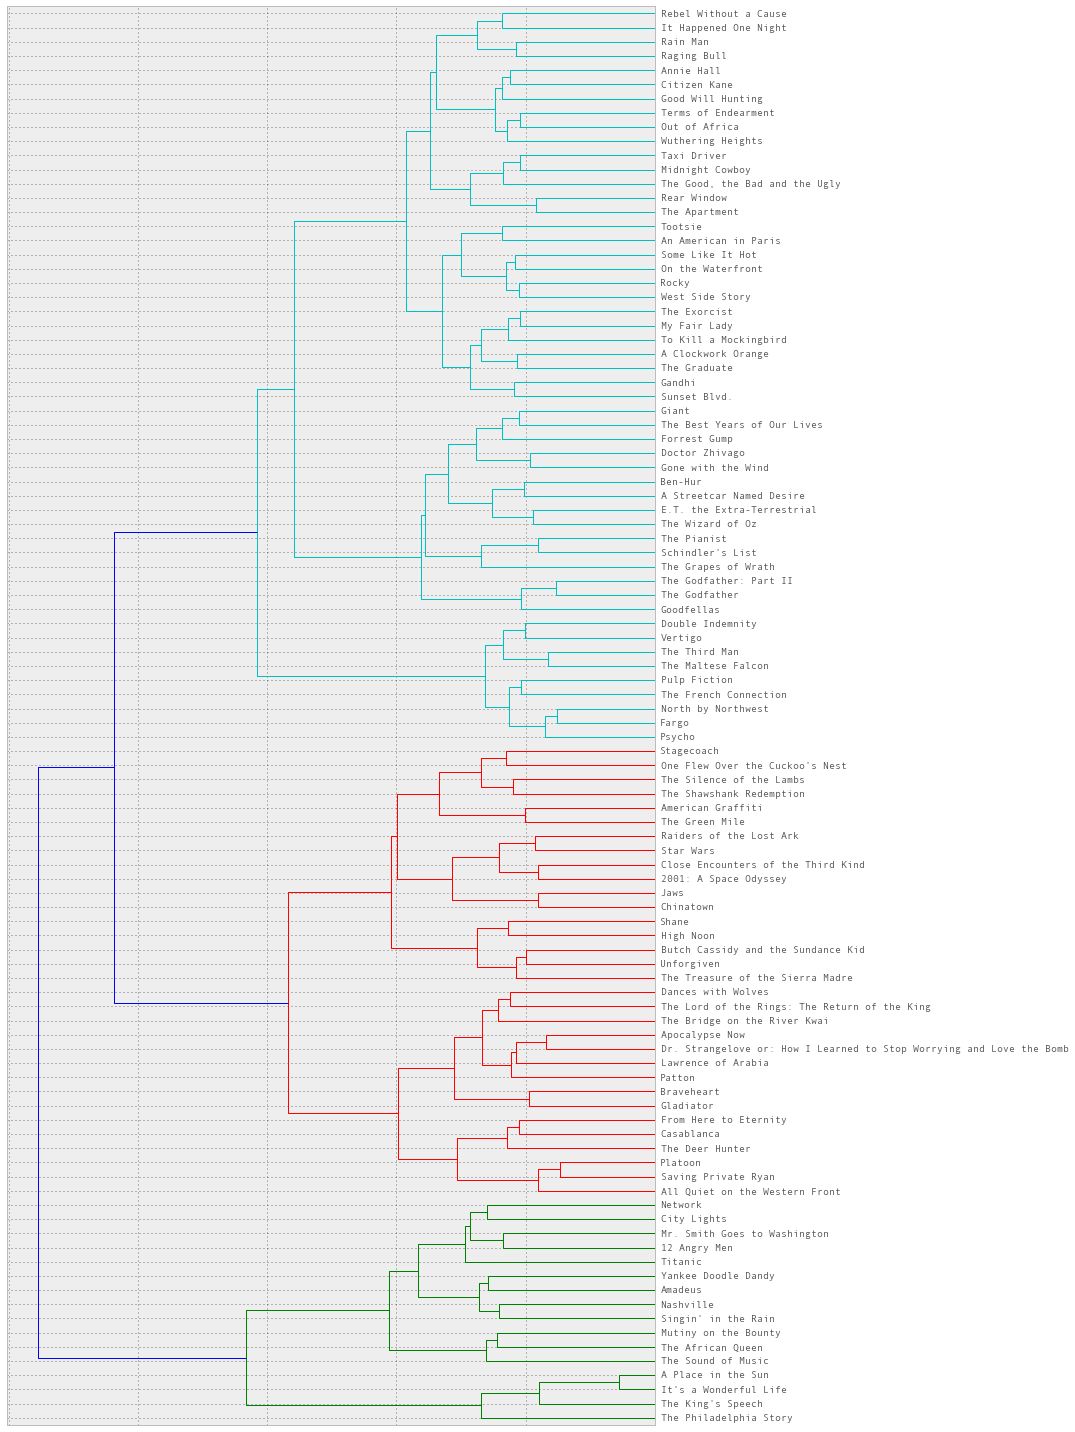

In [30]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [31]:
plt.close()

# Latent Dirichlet Allocation

In [32]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [33]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [34]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in synopses]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 5.86 s, sys: 126 ms, total: 5.98 s
Wall time: 6.27 s
CPU times: user 550 ms, sys: 10.6 ms, total: 561 ms
Wall time: 587 ms


/Users/bmabey/.virtualenvs/document_cluster/lib/python2.7/site-packages/numpy/lib/utils.py:95: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)
/Users/bmabey/.virtualenvs/document_cluster/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/bmabey/.virtualenvs/document_cluster/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/bmabey/.virtualenvs/document_cluster/lib/python2.7/site-packages/scipy/lib/_util.py:67: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/Users/bmabey/.virtualenvs/document_cluster/lib/python2.7/site-packages/s

In [35]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))

1839


In [36]:
dictionary = corpora.Dictionary(texts)

In [37]:
dictionary.filter_extremes(no_below=1, no_above=0.8)

In [38]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [39]:
len(corpus)

100

In [40]:
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 4min 6s, sys: 3.29 s, total: 4min 9s
Wall time: 4min 19s


In [41]:
print(lda[corpus[0]])

[(3, 0.66430173244078261), (4, 0.33532781815414342)]


In [50]:
lda.show_topics(num_words=10)

[u'0.005*home + 0.005*ship + 0.004*shark + 0.004*kill + 0.004*escap + 0.004*run + 0.003*two + 0.003*men + 0.003*away + 0.003*arriv',
 u'0.005*run + 0.004*suicid + 0.004*life + 0.004*first + 0.004*save + 0.004*tribe + 0.004*friend + 0.003*film + 0.003*decid + 0.003*new',
 u'0.005*fight + 0.005*war + 0.004*end + 0.004*kill + 0.004*ask + 0.004*love + 0.004*father + 0.004*brother + 0.003*meet + 0.003*forc',
 u"0.006*car + 0.005*kill + 0.005*ask + 0.005*n't + 0.005*go + 0.005*meet + 0.005*say + 0.005*polic + 0.004*arriv + 0.004*friend",
 u'0.008*kill + 0.005*order + 0.005*men + 0.005*offic + 0.005*soldier + 0.004*prison + 0.004*two + 0.004*villag + 0.003*command + 0.003*attack']

In [42]:
topics = lda.print_topics(5, num_words=20)

In [43]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)

In [44]:
topics_matrix = np.array(topics_matrix)

In [45]:
topics_matrix.shape

(5, 20, 2)

In [46]:
topic_words = topics_matrix[:,:,1]

In [47]:
for i in topic_words:
    print([str(word) for word in i])
    print()

['home', 'ship', 'shark', 'kill', 'escap', 'run', 'two', 'men', 'away', 'arriv', 'friend', 'go', 'use', 'night', 'help', 'order', 'come', 'soldier', 'water', 'say']

['run', 'suicid', 'life', 'first', 'save', 'tribe', 'friend', 'film', 'decid', 'new', 'away', 'love', 'mother', 'home', 'becom', 'follow', 'know', 'attempt', 'live', 'meet']

['fight', 'war', 'end', 'kill', 'ask', 'love', 'father', 'brother', 'meet', 'forc', 'marri', 'film', 'order', 'friend', 'men', 'son', 'becom', 'home', 'famili', 'learn']

['car', 'kill', 'ask', "n't", 'go', 'meet', 'say', 'polic', 'arriv', 'friend', 'father', 'day', 'night', 'famili', 'call', 'two', 'home', 'apart', 'want', 'doe']

['kill', 'order', 'men', 'offic', 'soldier', 'prison', 'two', 'villag', 'command', 'attack', 'die', 'famili', 'set', 'first', 'use', 'wound', 'fire', 'shoot', 'ask', 'boat']



# Visualizing LDA models

In [48]:
import pyLDAvis
import pyLDAvis.gensim as vis_gensim

In [53]:
vis_data = vis_gensim.prepare(lda, corpus, dictionary)

In [54]:
pyLDAvis.display(vis_data)

In [55]:
%time lda15 = models.LdaModel(corpus, num_topics=15, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 4min 11s, sys: 7.81 s, total: 4min 19s
Wall time: 4min 25s


In [56]:
pyLDAvis.enable_notebook()

In [57]:
vis_gensim.prepare(lda15, corpus, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      28.545922        1       1  0.045687  0.051512
12     14.559307        1       2  0.016128 -0.016390
13     10.708416        1       3  0.042460  0.031755
4       6.584368        1       4  0.048220  0.007164
5       6.268639        1       5  0.057887 -0.048012
2       5.451278        1       6 -0.007522  0.042471
10      4.783485        1       7  0.073390  0.038910
1       4.413200        1       8  0.051060 -0.006562
0       4.114339        1       9  0.041516  0.007720
9       3.380868        1      10 -0.020065  0.068039
6       2.453503        1      11  0.028189 -0.036304
3       2.377315        1      12  0.010771  0.024438
11      2.198807        1      13 -0.073372  0.042869
8       2.156748        1      14 -0.047100 -0.244099
14      2.003804        1      15 -0.267248  0.036488, topic_info=     Category        Freq      Term  Total  loglift  logprob
597   Default  273.000000     polic    273  30.0000  30.0000
3036  Default  366.000000    famili    366  29.0000  29.0000
3029  Default  214.000000   soldier    214  28.0000  28.0000
2567  Default  321.000000       car    321  27.0000  27.0000
6948  Default  635.000000      kill    635  26.0000  26.0000
4479  Default  339.000000    father    339  25.0000  25.0000
809   Default  121.000000      boat    121  24.0000  24.0000
282   Default  342.000000       men    342  23.0000  23.0000
4961  Default  255.000000      film    255  22.0000  22.0000
2450  Default  279.000000     fight    279  21.0000  21.0000
...       ...         ...       ...    ...      ...      ...
55    Topic15    8.844272      unit     57   1.9709  -5.6588
6309  Topic15    9.538245    report     97   1.5327  -5.5654
5918  Topic15    7.776492     match     43   2.1298  -5.7817
2648  Topic15   10.255121      year    198   0.8781  -5.5064
316   Topic15   10.276389      life    268   0.5822  -5.4996
6337  Topic15    8.559266  approach    104   1.3520  -5.6764
7294  Topic15    8.835217     stori    150   1.0154  -5.6467
4834  Topic15    8.754192       n't    404   0.0331  -5.6383
706   Topic15    8.344140       say    403  -0.0169  -5.6907
3854  Topic15    7.583765      lost     82   1.4587  -5.8073

[1848 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3089      7  1.000000       -smuggl
7057      2  0.857143         101st
4721     13  1.000000       12-foot
4371      7  1.000000     120-pound
2715      8  1.000000          13th
5953     10  1.000000          15th
3356     10  1.000000         1800s
5344      6  1.000000  200-year-old
6103      5  0.750000          25th
6008      1  1.000000        40-acr
...     ...       ...           ...
1494     10  0.011696         young
1494     11  0.029240         young
1494     12  0.011696         young
1494     14  0.093567         young
6523      1  0.846154       younger
6523      8  0.038462       younger
6523      9  0.038462       younger
6523     12  0.076923       younger
2824      4  1.000000        zenith
3019     10  1.000000         —fool

[4276 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 13, 14, 5, 6, 3, 11, 2, 1, 10, 7, 4, 12, 9, 15])

In [58]:
from copy import deepcopy
filtered_dictionary = deepcopy(dictionary)

In [59]:
filtered_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)
filtered_dictionary.compactify()
filtered_corpus = [filtered_dictionary.doc2bow(text) for text in texts]

In [60]:
%time lda_filtered_15 = models.LdaModel(filtered_corpus, num_topics=15, id2word=filtered_dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 2min 47s, sys: 3.5 s, total: 2min 50s
Wall time: 2min 56s


In [61]:
vis_gensim.prepare(lda_filtered_15, filtered_corpus, filtered_dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
13     10.203304        1       1 -0.009477 -0.212660
2       9.449281        1       2  0.019178  0.154526
6       8.979772        1       3 -0.024843 -0.029038
3       8.923402        1       4  0.067286  0.042623
7       8.196923        1       5 -0.110722  0.057301
1       8.076988        1       6 -0.028278 -0.003629
14      7.221101        1       7  0.014047 -0.036688
0       7.074385        1       8 -0.192769  0.029949
10      6.187452        1       9  0.134204  0.092952
9       5.758412        1      10 -0.072362 -0.017089
8       5.536853        1      11  0.006074 -0.020933
4       5.389240        1      12 -0.102109  0.006313
12      4.281876        1      13  0.083394  0.052443
5       3.164129        1      14  0.153243 -0.066839
11      1.556883        1      15  0.063135 -0.049231, topic_info=     Category        Freq          Term  Total  loglift  logprob
1147  Default  366.000000        famili    366  30.0000  30.0000
630   Default  321.000000           car    321  29.0000  29.0000
1138  Default  214.000000       soldier    214  28.0000  28.0000
1526  Default  172.000000        prison    172  27.0000  27.0000
1847  Default  187.000000       brother    187  26.0000  26.0000
550   Default  339.000000        father    339  25.0000  25.0000
422   Default  218.000000         apart    218  24.0000  24.0000
214   Default  239.000000        murder    239  23.0000  23.0000
112   Default  273.000000         polic    273  22.0000  22.0000
1636  Default  112.000000          sing    112  21.0000  21.0000
...       ...         ...           ...    ...      ...      ...
1106  Topic15    4.604441  neighborhood     45   1.8645  -5.5210
1346  Topic15    5.528583         charg     82   1.4446  -5.3409
214   Topic15    7.367338        murder    239   0.6598  -5.0559
951   Topic15    5.527750          rest     90   1.3515  -5.3409
432   Topic15    5.521204          deal    104   1.2069  -5.3409
630   Topic15    6.446133           car    321   0.2324  -5.1883
478   Topic15    5.551090          forc    196   0.5732  -5.3409
850   Topic15    4.627961          soon    138   0.7439  -5.5210
856   Topic15    4.618528       husband    116   0.9176  -5.5210
1231  Topic15    4.588887       sentenc     53   1.7009  -5.5210

[962 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
406       3  0.625000   abduct
406       9  0.375000   abduct
645       4  0.600000    abort
645       6  0.100000    abort
645      11  0.300000    abort
826       4  0.294118     abus
826       6  0.117647     abus
826      11  0.352941     abus
826      12  0.088235     abus
826      13  0.088235     abus
...     ...       ...      ...
187      13  0.166667  written
187      14  0.500000  written
1329      4  0.071429    youth
1329      5  0.642857    youth
1329      6  0.071429    youth
1329     11  0.142857    youth
548       3  0.153846     zone
548       6  0.153846     zone
548       7  0.076923     zone
548       8  0.538462     zone

[4416 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 3, 7, 4, 8, 2, 15, 1, 11, 10, 9, 5, 13, 6, 12])

In [63]:
%time lda_filtered_10 = models.LdaModel(filtered_corpus, num_topics=10, id2word=filtered_dictionary, update_every=5, chunksize=10000, passes=100)
vis_gensim.prepare(lda_filtered_10, filtered_corpus, filtered_dictionary)

CPU times: user 2min 50s, sys: 2.3 s, total: 2min 52s
Wall time: 2min 59s


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      22.416101        1       1  0.005837 -0.014863
6      13.539580        1       2 -0.006089  0.194669
3      11.241230        1       3 -0.030940 -0.060459
5       9.705044        1       4 -0.089739 -0.074748
7       9.168091        1       5 -0.007545 -0.039321
0       8.915632        1       6 -0.072539 -0.096758
8       7.654020        1       7 -0.073978  0.011073
1       6.079472        1       8 -0.007603  0.031947
9       5.789408        1       9  0.029710  0.115669
2       5.491421        1      10  0.252886 -0.067209, topic_info=     Category        Freq     Term  Total  loglift  logprob
1138  Default  214.000000  soldier    214  30.0000  30.0000
630   Default  321.000000      car    321  29.0000  29.0000
889   Default  121.000000     boat    121  28.0000  28.0000
1401  Default  152.000000    water    152  27.0000  27.0000
1147  Default  366.000000   famili    366  26.0000  26.0000
500   Default  143.000000     ship    143  25.0000  25.0000
112   Default  273.000000    polic    273  24.0000  24.0000
422   Default  218.000000    apart    218  23.0000  23.0000
1330  Default   66.000000    bridg     66  22.0000  22.0000
1611  Default  207.000000    marri    207  21.0000  21.0000
...       ...         ...      ...    ...      ...      ...
208   Topic10   15.474454      top     43   1.8675  -5.5634
113   Topic10   24.253135   travel    105   1.4115  -5.1267
809   Topic10   19.006051     note     65   1.6549  -5.3629
431   Topic10   26.164210      old    140   1.2021  -5.0484
397   Topic10   25.764700   mother    200   0.8277  -5.0661
667   Topic10   23.802371   inform    162   0.9629  -5.1416
413   Topic10   20.794441     save    121   1.1156  -5.2808
1462  Topic10   17.619591    chase     72   1.4782  -5.4373
622   Topic10   21.077687    peopl    149   0.9206  -5.2676
1088  Topic10   20.859228    woman    210   0.5695  -5.2755

[657 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
406      10  0.937500  abduct
749       5  0.073171  aboard
749       8  0.170732  aboard
749       9  0.073171  aboard
749      10  0.658537  aboard
280       1  0.437500  acquir
280       8  0.562500  acquir
1997      6  0.500000     add
1997      9  0.500000     add
95        3  0.666667   adult
...     ...       ...     ...
1674      8  0.023810   women
1674      9  0.023810   women
375       1  0.124088   wound
375       2  0.562044   wound
375       3  0.080292   wound
375       7  0.087591   wound
375       8  0.102190   wound
375       9  0.021898   wound
375      10  0.021898   wound
464       5  0.857143    wrap

[2362 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 4, 6, 8, 1, 9, 2, 10, 3])

In [64]:
%time lda_filtered_5 = models.LdaModel(filtered_corpus, num_topics=5, id2word=filtered_dictionary, update_every=5, chunksize=10000, passes=100)
vis_gensim.prepare(lda_filtered_5, filtered_corpus, filtered_dictionary)

CPU times: user 2min 43s, sys: 2.8 s, total: 2min 46s
Wall time: 2min 53s


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      27.049716        1       1  0.067140  0.056398
0      22.451036        1       2  0.125884 -0.009426
2      20.001198        1       3 -0.163159 -0.048650
3      16.375972        1       4 -0.052511  0.140714
1      14.122078        1       5  0.022646 -0.139036, topic_info=     Category        Freq      Term  Total  loglift  logprob
630   Default  321.000000       car    321  30.0000  30.0000
1138  Default  214.000000   soldier    214  29.0000  29.0000
112   Default  273.000000     polic    273  28.0000  28.0000
1526  Default  172.000000    prison    172  27.0000  27.0000
1975  Default  138.000000   command    138  26.0000  26.0000
475   Default  160.000000       war    160  25.0000  25.0000
500   Default  143.000000      ship    143  24.0000  24.0000
1401  Default  152.000000     water    152  23.0000  23.0000
266   Default  106.000000      camp    106  22.0000  22.0000
422   Default  218.000000     apart    218  21.0000  21.0000
...       ...         ...       ...    ...      ...      ...
964    Topic5   34.898287      real     74   1.1850  -5.7031
431    Topic5   44.201386       old    140   0.7798  -5.4707
1513   Topic5   39.591388  confront    115   0.8673  -5.5799
667    Topic5   44.418350    inform    162   0.6382  -5.4664
1071   Topic5   52.871312     escap    247   0.3886  -5.2942
850    Topic5   41.468810      soon    138   0.7308  -5.5341
550    Topic5   56.350454    father    339   0.1388  -5.2273
768    Topic5   43.271958     fight    279   0.0702  -5.4907
1147   Topic5   41.966508    famili    366  -0.2336  -5.5231
834    Topic5   36.741200      shot    176   0.3666  -5.6550

[383 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
749       4  0.975610  aboard
45        4  0.916667    abov
1185      1  0.504950  accept
1185      2  0.227723  accept
1185      3  0.168317  accept
1185      4  0.099010  accept
1845      1  0.862069  affair
1845      2  0.022989  affair
1845      4  0.080460  affair
1845      5  0.034483  affair
...     ...       ...     ...
1088      3  0.033333   woman
1088      4  0.109524   woman
1088      5  0.071429   woman
1674      1  0.607143   women
1674      3  0.154762   women
1674      5  0.226190   women
375       1  0.043796   wound
375       2  0.116788   wound
375       3  0.729927   wound
375       5  0.109489   wound

[824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 3, 4, 2])

In [65]:
%time lda_filtered_20 = models.LdaModel(filtered_corpus, num_topics=20, id2word=filtered_dictionary, update_every=5, chunksize=10000, passes=100)
vis_gensim.prepare(lda_filtered_20, filtered_corpus, filtered_dictionary)

CPU times: user 2min 46s, sys: 2.25 s, total: 2min 48s
Wall time: 2min 54s


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     21.380148        1       1  0.040364 -0.060700
12     11.239674        1       2 -0.015894 -0.015696
19      8.307120        1       3 -0.001156  0.026171
17      7.622883        1       4  0.052018 -0.060693
7       6.002322        1       5  0.003717 -0.040243
10      5.224168        1       6 -0.168225 -0.059804
2       4.890590        1       7 -0.009115  0.029178
1       4.329007        1       8  0.111082 -0.026682
9       3.565743        1       9  0.039434 -0.066817
0       3.494242        1      10 -0.216476  0.140955
8       3.407197        1      11 -0.029497 -0.058284
14      3.321068        1      12  0.031021 -0.088015
18      2.799270        1      13  0.018468 -0.018063
13      2.726244        1      14  0.142766 -0.004483
3       2.449519        1      15 -0.173740 -0.022803
4       2.208342        1      16 -0.039453 -0.041636
15      1.968196        1      17  0.094460  0.053216
11      1.945021        1      18 -0.076601 -0.018499
6       1.917377        1      19  0.053463  0.288474
5       1.201868        1      20  0.143365  0.044426, topic_info=     Category        Freq     Term  Total  loglift  logprob
1138  Default  214.000000  soldier    214  30.0000  30.0000
1526  Default  172.000000   prison    172  29.0000  29.0000
630   Default  321.000000      car    321  28.0000  28.0000
500   Default  143.000000     ship    143  27.0000  27.0000
422   Default  218.000000    apart    218  26.0000  26.0000
550   Default  339.000000   father    339  25.0000  25.0000
1147  Default  366.000000   famili    366  24.0000  24.0000
1847  Default  187.000000  brother    187  23.0000  23.0000
214   Default  239.000000   murder    239  22.0000  22.0000
950   Default  227.000000    money    227  21.0000  21.0000
...       ...         ...      ...    ...      ...      ...
290   Topic20    6.233175   report     97   1.6537  -4.9637
40    Topic20    6.089749  marriag     93   1.6638  -4.9958
659   Topic20    5.474389     spot     74   1.8060  -5.0821
1308  Topic20    6.898098    stori    150   1.3139  -4.8677
283   Topic20    6.030884     busi    105   1.5482  -4.9900
2014  Topic20    5.482768  success     77   1.7533  -5.0951
1611  Topic20    6.049448    marri    207   0.8621  -4.9973
550   Topic20    6.354637   father    339   0.4199  -4.9463
1387  Topic20    5.166108   someth     87   1.5837  -5.1426
834   Topic20    5.152729     shot    176   0.8712  -5.1504

[1241 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1177      1  0.092593  abandon
1177      6  0.092593  abandon
1177      7  0.129630  abandon
1177      8  0.074074  abandon
1177      9  0.037037  abandon
1177     13  0.111111  abandon
1177     15  0.148148  abandon
1177     17  0.148148  abandon
1177     18  0.018519  abandon
1177     19  0.111111  abandon
...     ...       ...      ...
35       19  0.391304    wreck
1362      4  0.600000   writer
1362      8  0.150000   writer
1362     10  0.100000   writer
1362     17  0.100000   writer
187       2  0.277778  written
187       8  0.555556  written
187      20  0.166667  written
548       6  0.769231     zone
548      18  0.153846     zone

[5579 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 13, 20, 18, 8, 11, 3, 2, 10, 1, 9, 15, 19, 14, 4, 5, 16, 12, 7, 6])